Compare the performance of VICE, DDL, and DynamicsAwareEmbeddingVICE on the Maze-v0 task.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage
from matplotlib.patches import Rectangle
import json
import pandas as pd

In [5]:
common_dir = '/home/kevinli/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [16]:
def load_progress_for_all_paths(paths):
    progress = {}
    
    for exp_num, exp_path in paths.items():
        seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
        seeds = [seed for seed in seeds if os.path.isdir(seed)]
        exp_data = {}
        for i, seed in enumerate(seeds):
        #     print(f'{i} \t {seed.replace(exp_path, "")}')
            try:
                progress_file = os.path.join(seed, "progress.csv")
                df = pd.read_csv(progress_file)
                exp_data[seed] = df
            except Exception as e:
                print(e)

        print(f"Loaded {len(progress_data)} seeds from {exp_path.split('/')[-1]}")
        progress[exp_num] = exp_data

    return progress

In [196]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')

exp_choices = input('\n Which experiment(s) do you want to analyze? (ENTER A NUMBER) \t')
exp_numbers = []
for num in exp_choices.split(","):
    exp_numbers.append(int(num))

exp_paths = {num: exps[num] for num in exp_numbers}
progress_data = load_progress_for_all_paths(exp_paths)

0 	 /2020-05-27T16-46-37-ddl_maze
1 	 /2020-05-27T18-08-07-ddl_maze_count
2 	 /2020-05-28T03-25-55-vice_test
3 	 /2020-05-28T03-28-00-vice_test
4 	 /2020-05-28T03-31-57-vice_test
5 	 /2020-05-28T03-33-32-vice_test
6 	 /2020-05-28T03-44-54-vice_test
7 	 /2020-05-28T15-34-01-dynamics_aware_vice
8 	 /2020-05-29T03-42-04-dynamics_aware_vice_shorter_paths
9 	 /2020-05-29T03-47-53-vice_only
10 	 /2020-05-29T16-15-18-vice_only_final
11 	 /2020-05-31T05-25-18-vice_gt_embedding
12 	 /2020-06-02T02-47-31-vice_gt_embedding_rerun
13 	 /2020-06-02T03-22-25-vice_gt_embedding_more_reg
14 	 /2020-06-02T10-48-03-vice_gt_embedding_again
15 	 /2020-06-03T00-23-13-high_reg_vice
16 	 /2020-06-03T06-19-35-vice_dropout_and_wd
17 	 /2020-06-04T16-33-57-vice_gt_pairwise_embedding
18 	 /2020-06-05T00-51-54-vice_gt_pairwise_embedding_rerun
19 	 /2020-06-05T00-52-40-vice_gt_pairwise_embedding_rerun
20 	 /2020-06-05T01-03-06-vice_gt_pairwise_embedding_rerun_real
21 	 /2020-06-05T11-52-19-vice_gt_pairwise_embedding

In [199]:
def double_std(a):
    return 2 * np.std(a)

def plot_stat(progress_data, stats, labels):
    plt.figure(figsize=(16,8))
    colors = ['r', 'g', 'b', 'c']
    for i, (exp_num, exp_data) in enumerate(progress_data.items()):
        results_all_seeds = [df.filter(stats) for df in exp_data.values()]
        combined_results = pd.concat(results_all_seeds).groupby(level=0).mean()
        
        plt.plot(combined_results, color=colors[i], linewidth=2, label=labels[i])
        
        for result in results_all_seeds:
            plt.plot(result, color=colors[i], alpha=0.08)
    
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}k"))
    plt.ylim(0, 22)
    plt.xlabel("Training steps")
    plt.ylabel("Manhattan distance to goal")
    plt.title("Medium Maze-v0")
    plt.legend()
    plt.show()

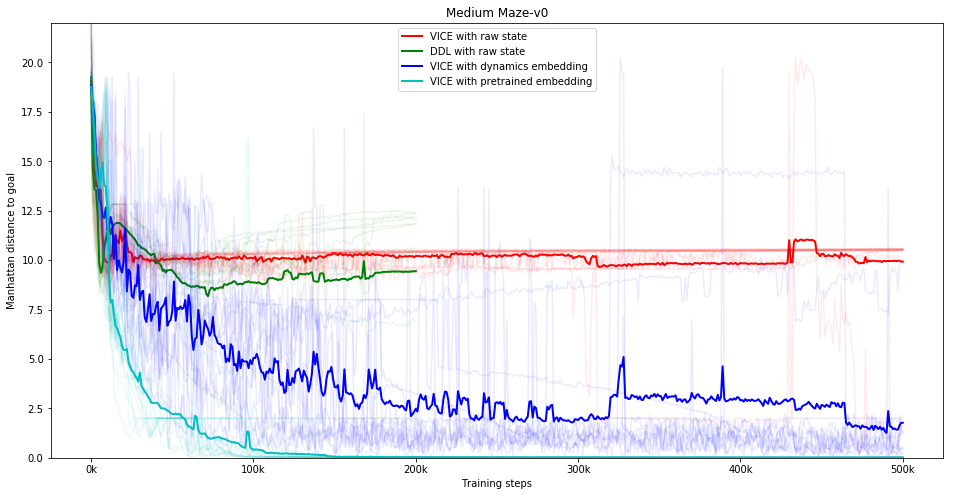

In [200]:
plot_stat(progress_data, ['evaluation/env_infos/manhattan_dist_to_target-last-mean'], ['VICE with raw state', 'DDL with raw state', 'VICE with dynamics embedding', 'VICE with pretrained embedding'])